In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import tqdm
from tqdm.keras import TqdmCallback

import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MultipleLocator

import src

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [3]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

### Setup for data

In [4]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
    'Test 24',
    'Test 25',
    'Test 26',
    'Test 28',
    'Test 30',
    'Test 31',
    'Test 32',
    'Test 34'
]

exps = [src.load(label) for label in expLabels]

In [5]:
# Add two features for the 350-360 kHz and 900-910 kHz frequency bands

freq = [35, 90]

for i, exp in enumerate(exps):
    f = np.array(exp.ae.fft[1000])
    # avg over 10kHz
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T
    for fr in freq: 
        fNew = np.concatenate(([np.NaN], f[fr]))
        exp.features[f'Freq {fr * 10} kHz'] = fNew

### Parameters

In [6]:
doc = 0.03    # Depth of cut (mm)
tol = 0.0015   # Tolerance (mm)
# tol = 0.002   # Tolerance (mm)
overall_tol = 0.02 # Overall tolerance (mm)

# Multiclass classification (Wear In, Steady State, Wear Out)

There should be three categories of probe data relating to the three stages of tool wear:
1. Initial rapid wear in
2. Steady state wear (Much longer in time period)
3. Rapid wear out from tool failure

Therefore each test should have two crossing points to determine the three catergories.

Labelling Key:
- 0: Stage 1 (Wear in)
- 1: Stage 2 (Steady state)
- 2 : Stage 3 (Wear out)

## Data Preprocesssing & Labelling

In [7]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_9220\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_9220\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


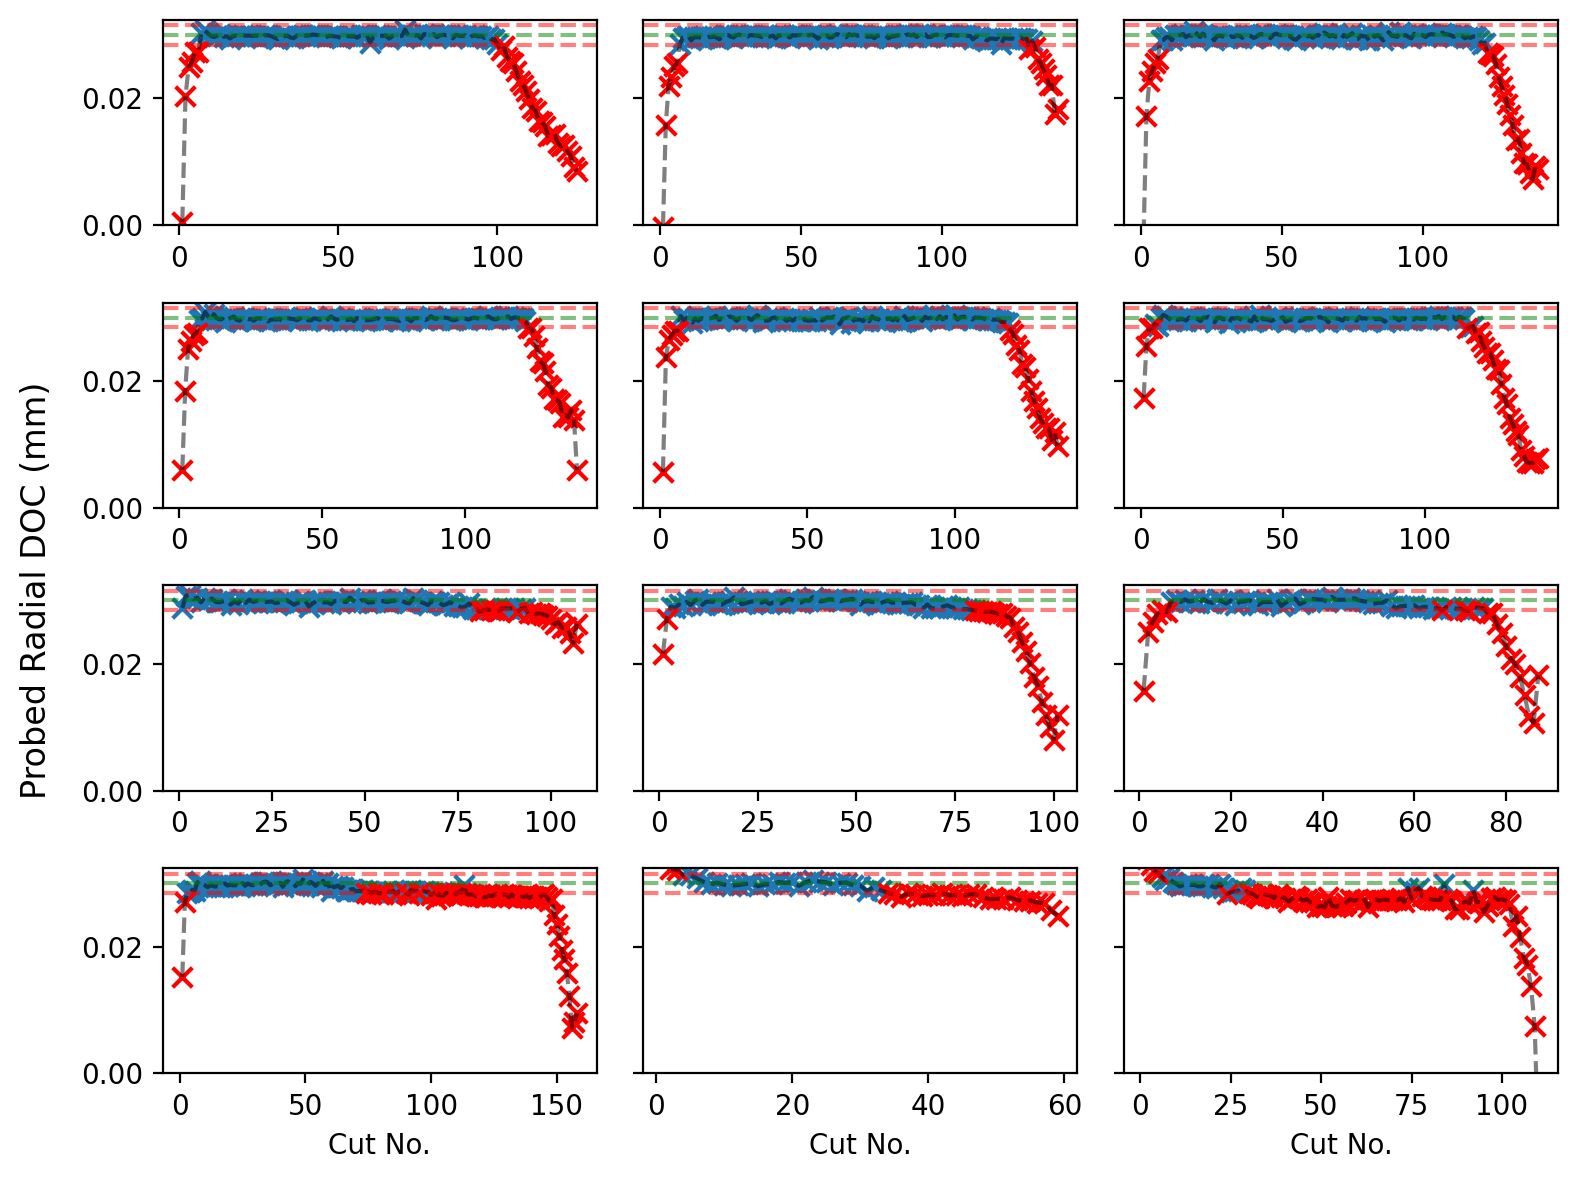

In [33]:
crossings = []

fig, ax = plt.subplots(4, 3, figsize=(8, 6), sharey=True, dpi=200)
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].set_ylim(0, )

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)

    crossing = []
    for ix in x[tol_bool]:
        # if ix == 0:
        #     continue
        # if ix == len(x) - 1:
        #     continue
        if ix - 1 not in x[tol_bool]:
            crossing.append(ix)
        elif ix + 1 not in x[tol_bool]:
            crossing.append(ix)

    # if len(crossing) != 2:
    #     ix = np.argmax(np.diff(crossing))
    #     crossing = crossing[ix:ix+2]
    if crossing[1] > 10:
        crossing = [crossing[0], crossing[1]]
    else:
        crossing = [crossing[1], crossing[2]]

    # diff = np.diff(crossing)
    # crossing = [crossing[np.argmax(diff)], crossing[np.argmax(diff) + 1]]
    crossings.append(crossing)

    if i >8:
        ax[i].set_xlabel('Cut No.')
    fig.supylabel('Probed Radial DOC (mm)')

fig.tight_layout()


In [34]:
# test 8 has no wear in stage
# crossings[7][0] = 0
crossings

[[6, 101],
 [6, 131],
 [6, 123],
 [6, 122],
 [6, 119],
 [4, 115],
 [0, 81],
 [2, 80],
 [6, 66],
 [2, 74],
 [3, 34],
 [5, 24]]

In [35]:
# Multi-class classification
categories = []
for df, cr in zip(dfs, crossings):
    categories.append(np.ones(len(df), dtype=int))
    categories[-1][:cr[0] + 1] = 0
    categories[-1][cr[1]:] = 2
    df['Probe class'] = categories[-1]

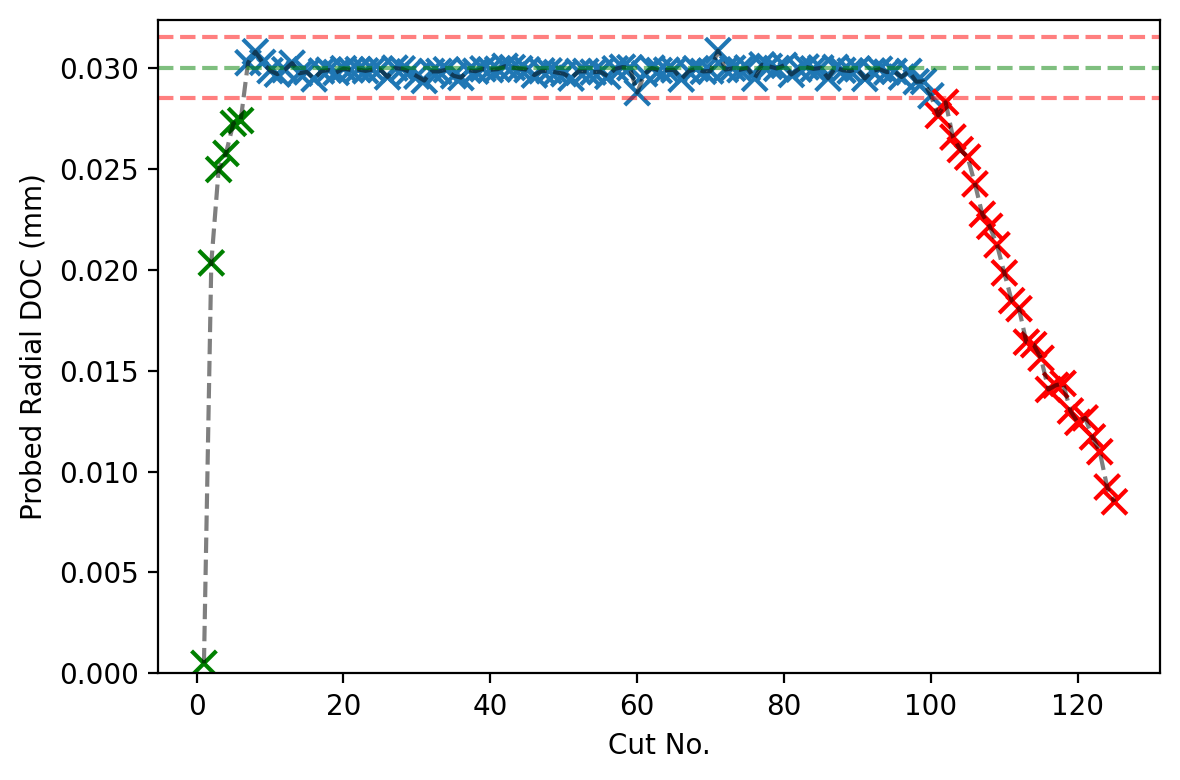

In [53]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

y = dfs[0]['Probe diff']
x = np.arange(len(y))

ax.plot(x, y, color='k', alpha=0.5, linestyle='--')
ax.set_ylim(0, )

ax.axhline(doc, color='g', ls='--', alpha=0.5)
ax.axhline(doc - tol, color='r', ls='--', alpha=0.5)
ax.axhline(doc + tol, color='r', ls='--', alpha=0.5)
c = ['g' if x == 0 else 'r' if x == 2 else 'C0' for x in dfs[0]['Probe class']]
ax.scatter(x, y, c=c, cmap='coolwarm', marker='x', s=80)

ax.set_ylabel('Probed Radial DOC (mm)')
ax.set_xlabel('Cut No.')

fig.tight_layout()

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


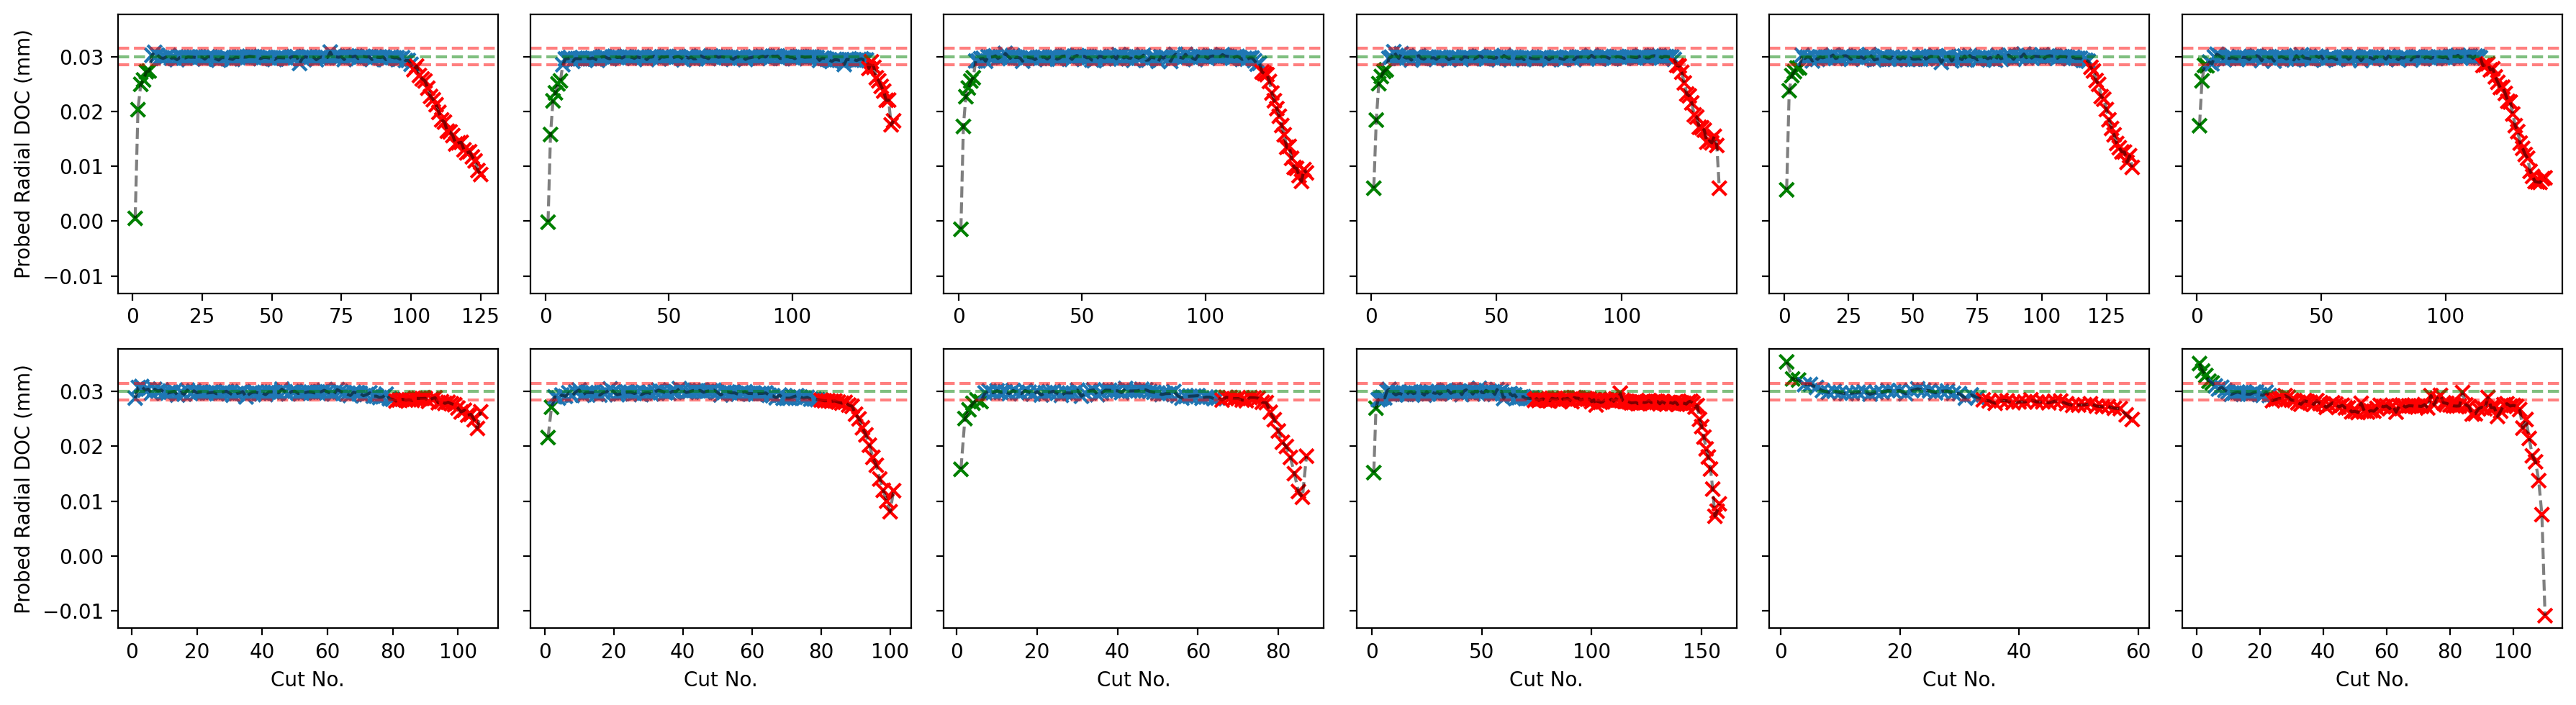

In [123]:
# scatter plot with color coding for classes

fig, ax = plt.subplots(2, 6, figsize=(18, 5), sharey=True, dpi=200)
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')
    # ax[i].set_ylim(0, 0.032 )

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == 0 else 'r' if x == 2 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)

    if i in [0, 6]:
        ax[i].set_ylabel('Probed Radial DOC (mm)')
    if i > 5:
        ax[i].set_xlabel('Cut No.')

fig.tight_layout()

## ML Data Setup

In [102]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1443 rows x 10 cols


RMS   Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0  0.165769  13.370745   3.526970  0.405907    30.444512    44.679891   
1  0.867455   6.003787   9.724098  0.199650    32.996937    59.681803   
2  0.925335   4.987960  12.566137  0.142104    32.163762    63.341659   
3  0.976617   4.957906   9.321526  0.122387    32.044878    64.356581   
4  1.010500   4.814915   9.827996  0.100560    32.245993    64.648060   

   Freq 134 kHz  Freq 350 kHz  Freq 900 kHz  Probe class  
0     32.198906     12.909057    -11.821563            0  
1     48.568199     27.129176     -5.134317            0  
2     49.415402     27.754227     -5.150741            0  
3     49.721967     27.474832     -5.686634            0  
4     49.973477     27.530558     -5.821156            0

In [103]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1443 rows x 9 cols
Target df : 1443 rows x 3 cols


In [104]:
target_df

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [105]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 3.60%
Class 1: 69.72%
Class 2: 26.68%


In [106]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=41,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 1010 samples
Testing set: 433 samples


In [107]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

## Classification Model

### Setup

In [108]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [109]:
mlp.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.76 KB)

 Trainable params: 1,475 (5.76 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [111]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1000,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1000/1000 [01:48<00:00,  9.26epoch/s, accuracy=0.988, f1_score=tf.Tensor([0.9863013  0.9914893  0.97951573], shape=(3,), dtype=float32), loss=0.0384, val_accuracy=0.963, val_f1_score=tf.Tensor([0.9333333  0.97368413 0.9385964 ], shape=(3,), dtype=float32), val_loss=0.147]


Text(0, 0.5, 'Loss')

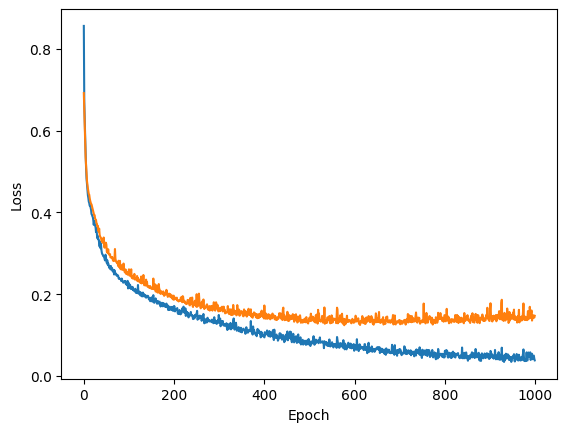

In [112]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [113]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9630
F1_score: [0.9333333  0.97368413 0.9385964 ]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction we choose the class with the highest probability.

In [114]:
y_pred = mlp.predict(input_df, verbose=0)

In [115]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

### Confusion matrix

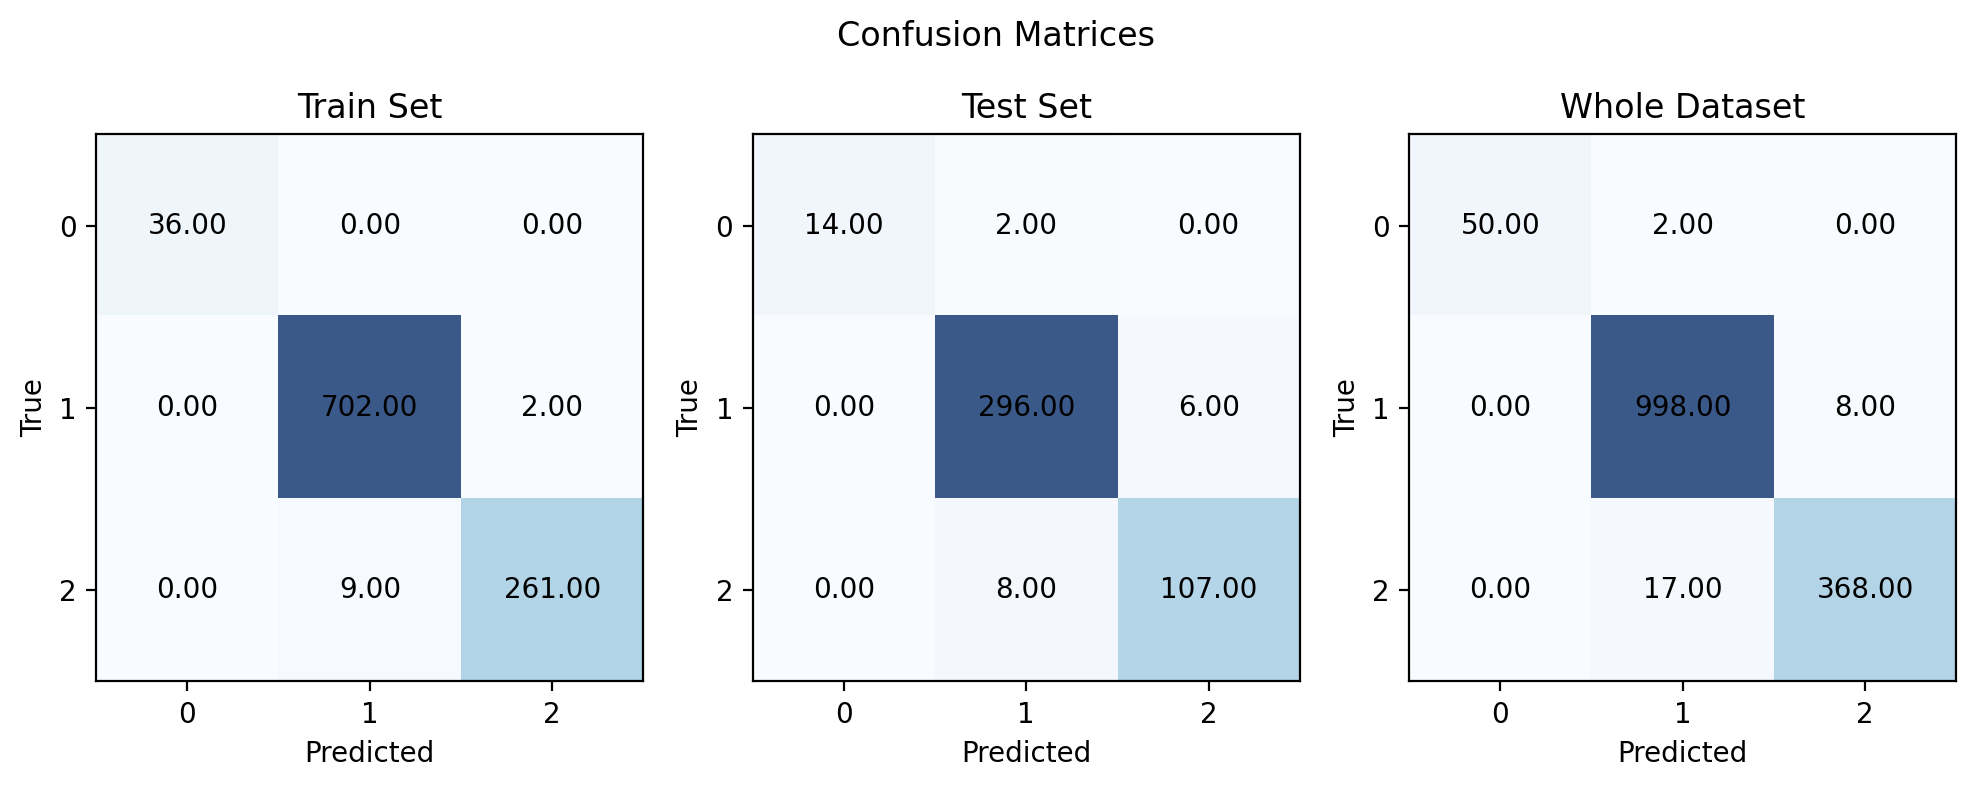

In [125]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    # cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.2f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')


### Classification Visualisation

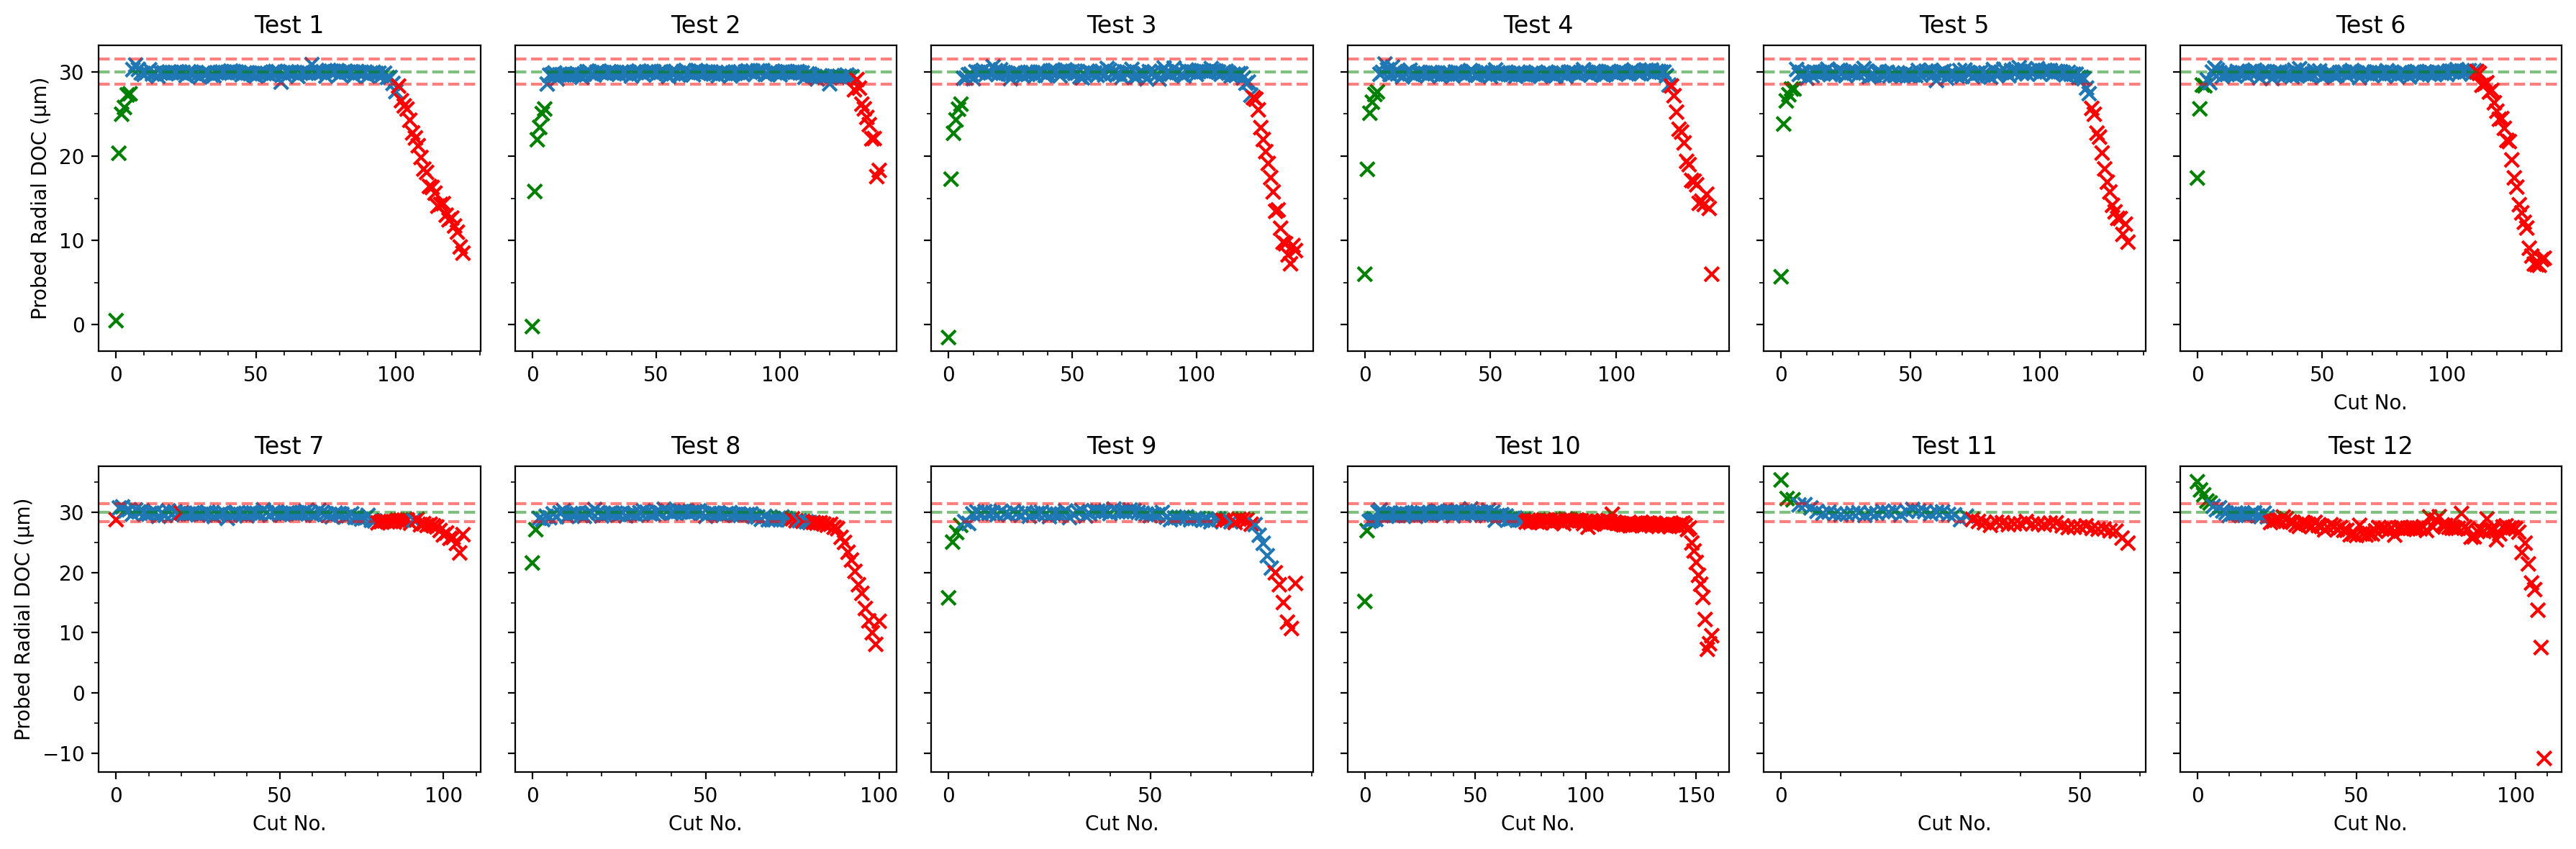

In [118]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 0] = 'g'
col[pred_df['Probe pred'] == 2] = 'r'

fig, ax = plt.subplots(2, 6, figsize=(18, 6), dpi=200, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(dfs)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 6:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

# Binary classification (In Tol, Out Tol)

Only use two classes in or out of tolerance for probe doc.

Labelling Key:
- 0 : In tolerance
- 1 : Out of tolerance

## Data Preprocesssing & Labelling

In [10]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_35444\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_35444\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


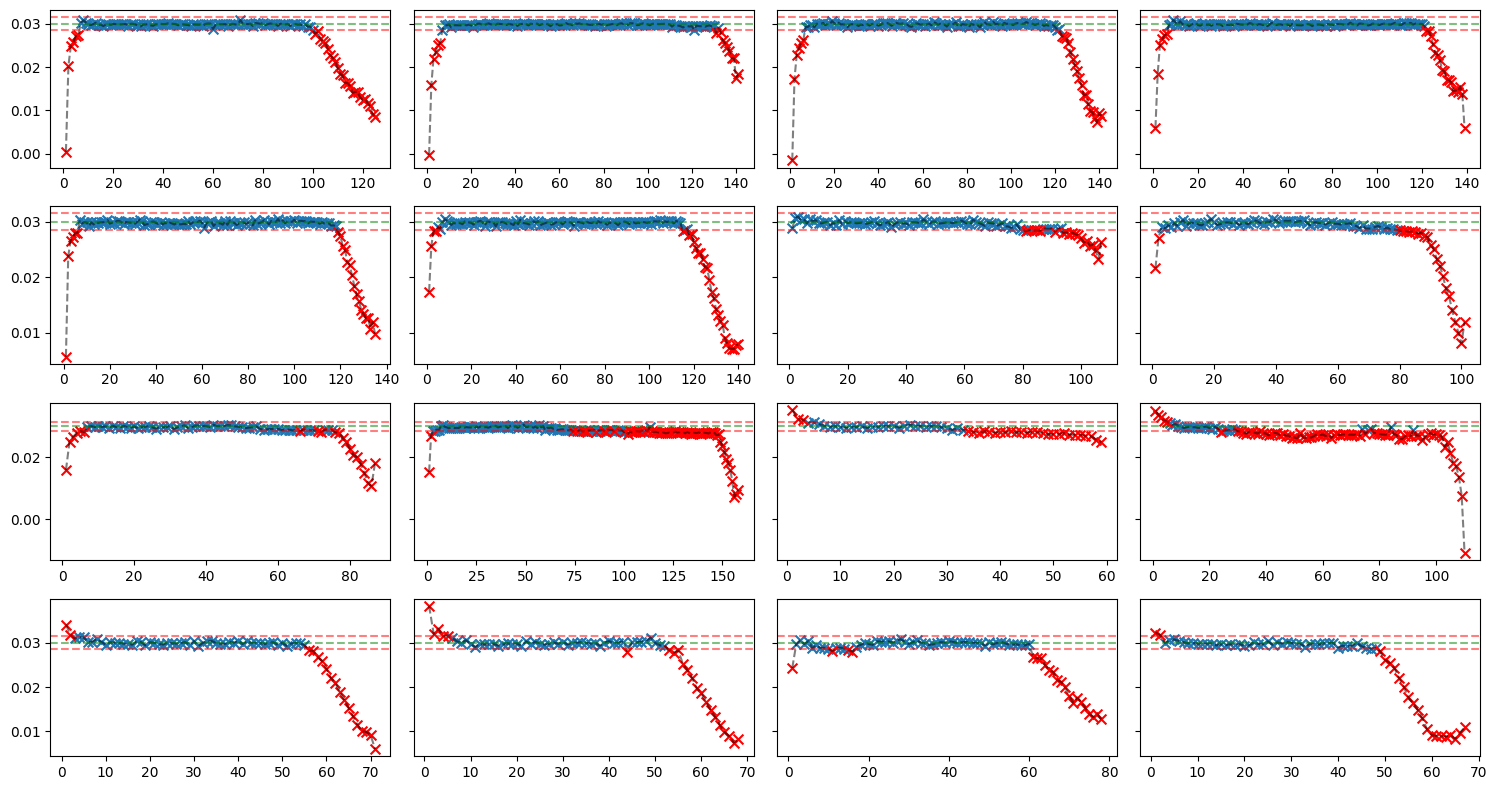

In [11]:
categories = []

fig, ax = plt.subplots(4, 4, figsize=(15, 8), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)
    categories.append(tol_bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)
fig.tight_layout()


In [12]:
# Multi-class classification
for df, cat in zip(dfs, categories):
    df['Probe class'] = cat 

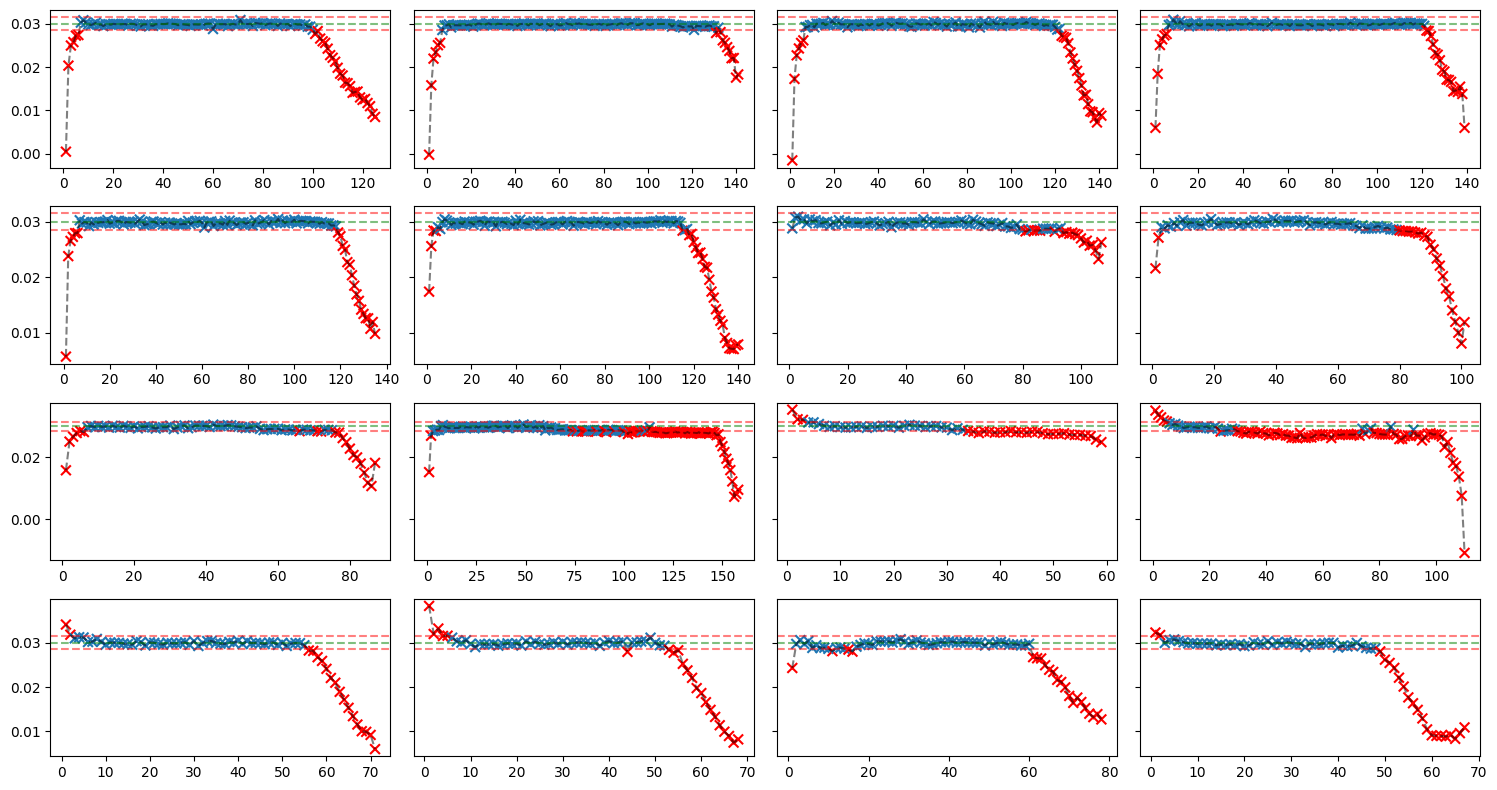

In [15]:
# scatter plot with color coding for classes

fig, ax = plt.subplots(4, 4, figsize=(15, 8), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [16]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1727 rows x 10 cols


RMS   Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0  0.165769  13.370745   3.526970  0.405907    30.444512    44.679891   
1  0.867455   6.003787   9.724098  0.199650    32.996937    59.681803   
2  0.925335   4.987960  12.566137  0.142104    32.163762    63.341659   
3  0.976617   4.957906   9.321526  0.122387    32.044878    64.356581   
4  1.010500   4.814915   9.827996  0.100560    32.245993    64.648060   

   Freq 134 kHz  Freq 350 kHz  Freq 900 kHz  Probe class  
0     32.198906     12.909057    -11.821563         True  
1     48.568199     27.129176     -5.134317         True  
2     49.415402     27.754227     -5.150741         True  
3     49.721967     27.474832     -5.686634         True  
4     49.973477     27.530558     -5.821156         True

In [17]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1727 rows x 9 cols
Target df : 1727 rows x 2 cols


In [18]:
target_df

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [19]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 72.67%
Class 1: 27.33%


In [20]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 1208 samples
Testing set: 519 samples


In [21]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

In [22]:
from sklearn.decomposition import PCA
pca_input = input_df.copy()
pca_input = PCA(n_components=5).fit_transform(pca_input)

In [23]:
pca_input.shape

(1727, 5)

## Classification Model

### Setup

In [24]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [25]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [27]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1000,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1000/1000 [02:00<00:00,  8.28epoch/s, accuracy=0.959, f1_score=tf.Tensor([0.97217476 0.9251908 ], shape=(2,), dtype=float32), loss=0.0885, val_accuracy=0.944, val_f1_score=tf.Tensor([0.96138483 0.89895463], shape=(2,), dtype=float32), val_loss=0.185]


Text(0, 0.5, 'Loss')

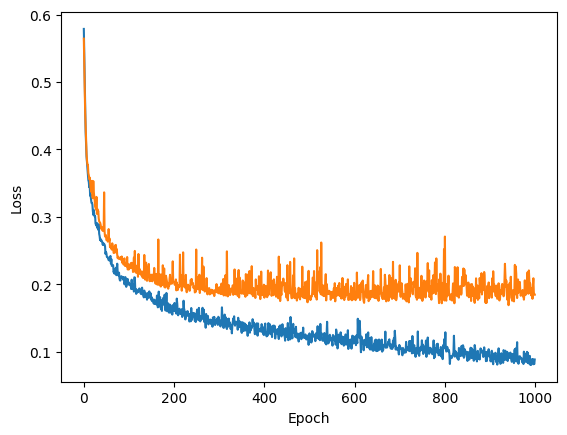

In [28]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [29]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9441
F1_score: [0.96138483 0.89895463]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction could choose the class with the highest probability, or set a threshold to determine the class.

In [30]:
y_pred = mlp.predict(input_df, verbose=0)

In [31]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

In [32]:
# Threshold based class prediction
threshold = 0.5
y_pred_class = y_pred[:, 1] > threshold

### Confusion matrix

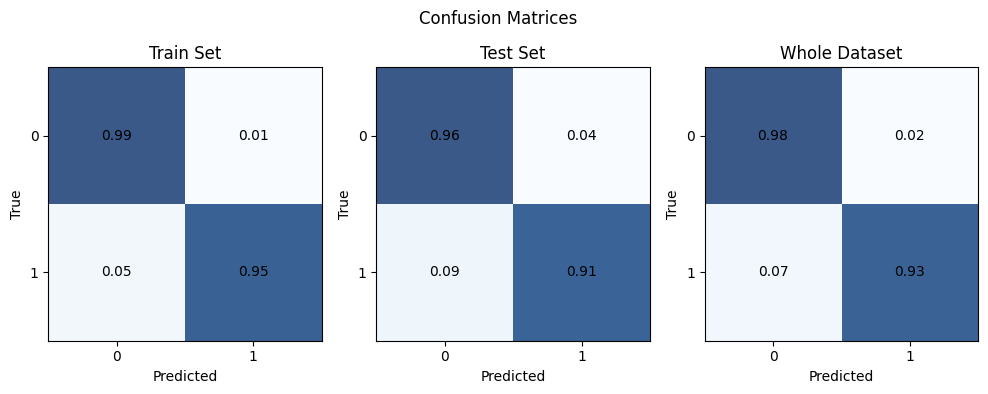

In [33]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.2f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')


### Classification Visualisation

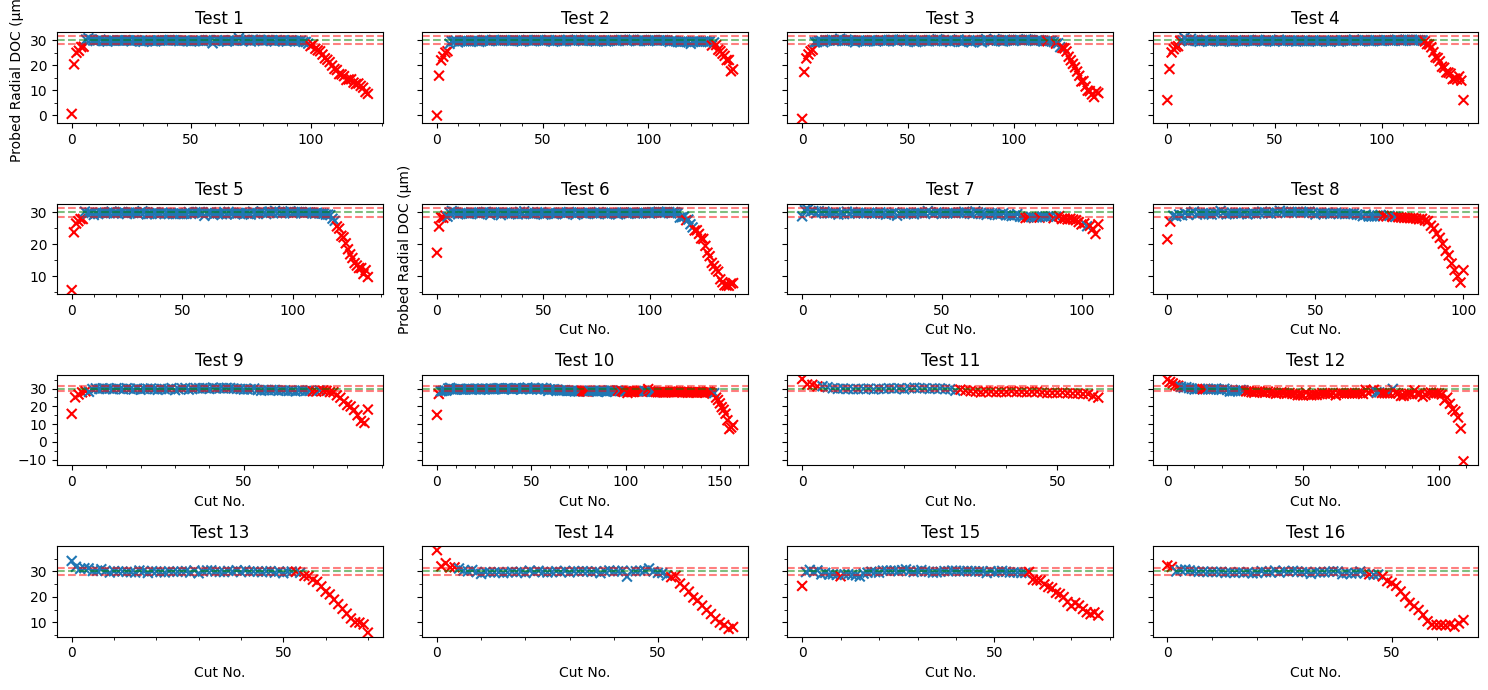

In [35]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 1] = 'r'

fig, ax = plt.subplots(4, 4, figsize=(15, 7), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(dfs)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 5:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

# Binary classification without wear in data (Steady State, Wear Out)

Wear out is more important to detect than wear in. Therefore, how would classifcation change if we solely focused on wear out data?

Therefore only two classes are used in this case.

Labelling Key:
- 0: Stage 2 (Steady state)
- 1 : Stage 3 (Wear out)

## Data Preprocesssing & Labelling

In [ ]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_26152\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_26152\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


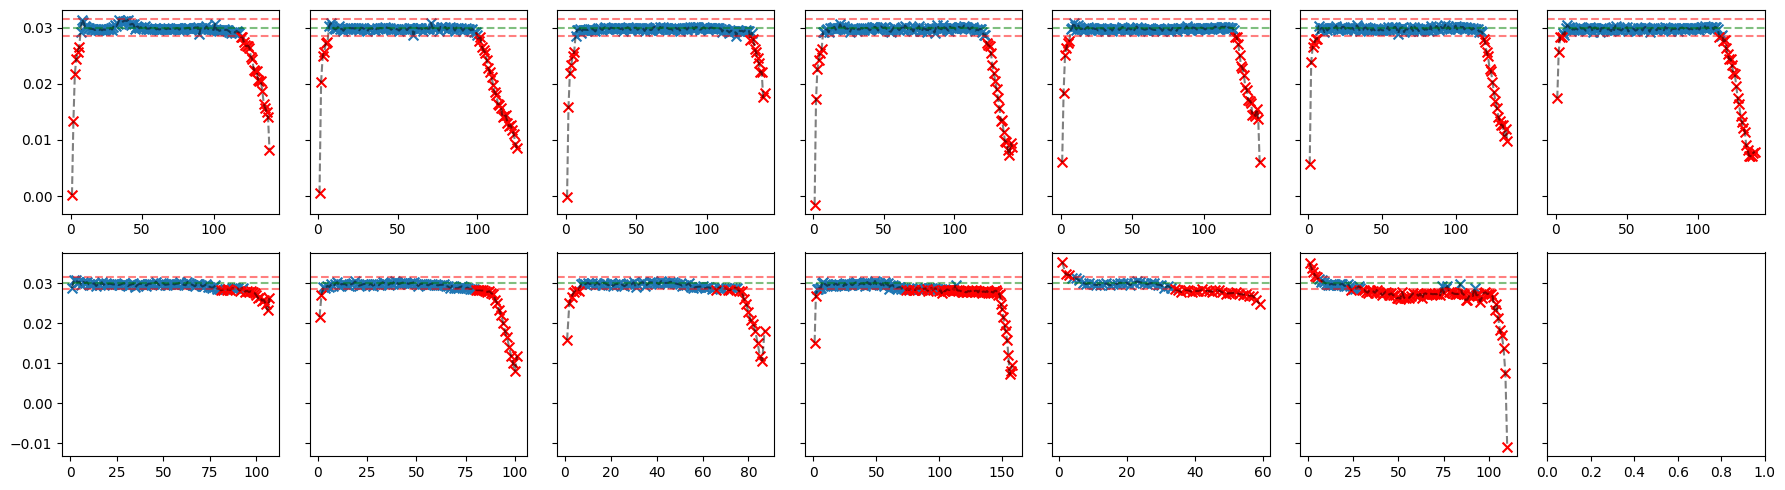

In [ ]:
crossings = []

fig, ax = plt.subplots(2, 7, figsize=(18, 5), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)

    crossing = []
    for ix in x[tol_bool]:
        # if ix == 0:
        #     continue
        # if ix == len(x) - 1:
        #     continue
        if ix - 1 not in x[tol_bool]:
            crossing.append(ix)
        elif ix + 1 not in x[tol_bool]:
            crossing.append(ix)

    # if len(crossing) != 2:
    #     ix = np.argmax(np.diff(crossing))
    #     crossing = crossing[ix:ix+2]
    # diff = np.diff(crossing)
    # crossing = [crossing[np.argmax(diff)], crossing[np.argmax(diff) + 1]]
    if crossing[1] > 10:
        crossing = [crossing[0], crossing[1]]
    else:
        crossing = [crossing[1], crossing[2]]

    # crossing = [crossing[1], crossing[-2]]
    crossings.append(crossing)

fig.tight_layout()


In [ ]:
# test 8 has no wear in stage
# crossings[7][0] = 0
crossings

[[6, 119],
 [6, 101],
 [6, 131],
 [6, 123],
 [6, 122],
 [6, 119],
 [4, 115],
 [0, 81],
 [2, 80],
 [6, 66],
 [2, 74],
 [3, 34],
 [5, 24]]

In [ ]:
# Multi-class classification
categories = []
for df, cr in zip(dfs, crossings):
    categories.append(np.zeros(len(df), dtype=int))
    categories[-1][:cr[0] + 1] = -1
    categories[-1][cr[1]:] = 1
    df['Probe class'] = categories[-1]

In [ ]:
# Remove all data with category of -1 
for df, cat in zip(dfs, categories):
    df['Probe class'] = cat
    df.drop(df[df['Probe class'] == -1].index, inplace=True)

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


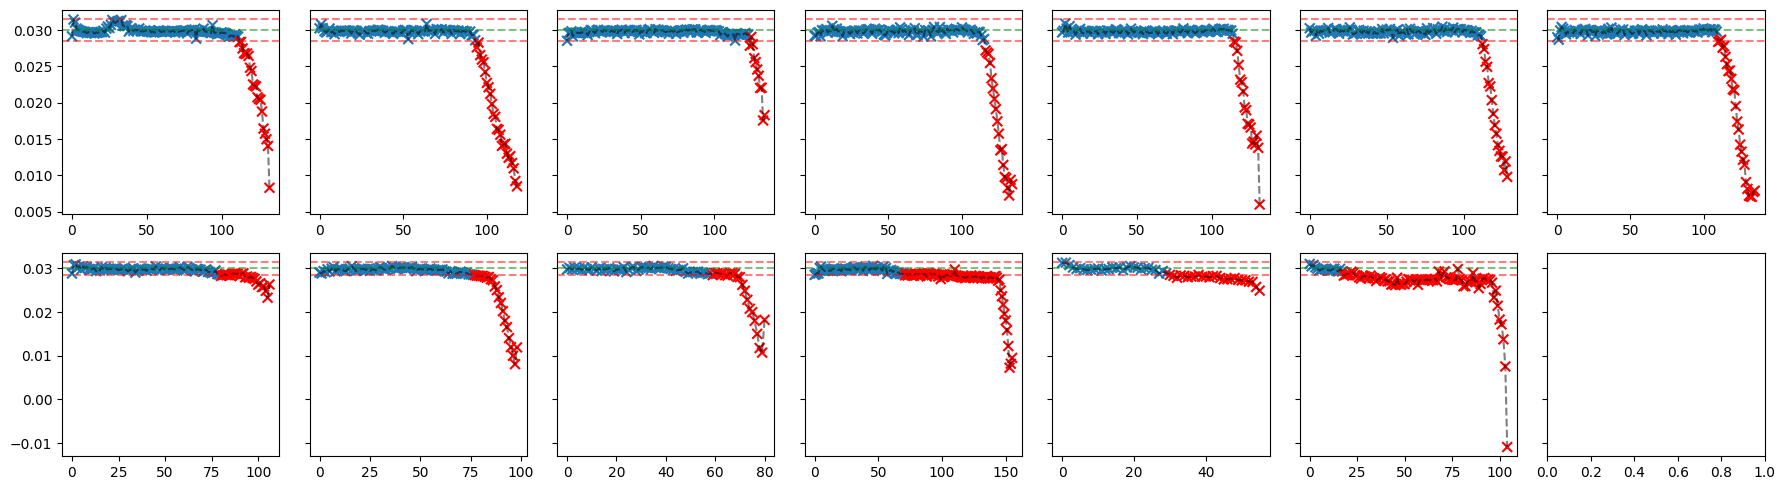

In [ ]:
# scatter plot with color coding for classes
fig, ax = plt.subplots(2, 7, figsize=(18, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['C0' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [ ]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1524 rows x 10 cols


RMS  Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0  1.018375  5.347006  11.570679 -0.088832    34.427976    66.918001   
1  1.009624  5.263375   8.932589 -0.076673    34.011602    67.002293   
2  1.020696  5.053545   8.965567 -0.080030    34.109063    67.436460   
3  1.044284  5.061466   9.420055 -0.091577    34.196497    67.539986   
4  1.045896  4.991534  10.239016 -0.086686    34.402094    67.449424   

   Freq 134 kHz  Freq 350 kHz  Freq 900 kHz  Probe class  
0     48.981869     26.650652    -10.713671            0  
1     49.102665     26.525174    -10.916002            0  
2     49.450305     26.476995    -10.993286            0  
3     49.570803     26.377297    -11.133766            0  
4     49.715149     26.336164    -11.347432            0

In [ ]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1524 rows x 9 cols
Target df : 1524 rows x 2 cols


In [ ]:
target_df

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 73.36%
Class 1: 26.64%


In [ ]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
# idx_val = idx[dfLen[-2]:]
# idx = idx[:dfLen[-2]]
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=target_df[idx],
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 1066 samples
Testing set: 458 samples


In [ ]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

## Classification Model

### Setup

In [ ]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(16, activation='relu'))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [ ]:
mlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 882 (3.45 KB)

 Trainable params: 882 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [ ]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=1500,
                  batch_size=32,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 1500/1500 [02:45<00:00,  9.05epoch/s, accuracy=0.988, f1_score=tf.Tensor([0.9916932  0.97707224], shape=(2,), dtype=float32), loss=0.0267, val_accuracy=0.974, val_f1_score=tf.Tensor([0.98219573 0.9504131 ], shape=(2,), dtype=float32), val_loss=0.131]


Text(0, 0.5, 'Loss')

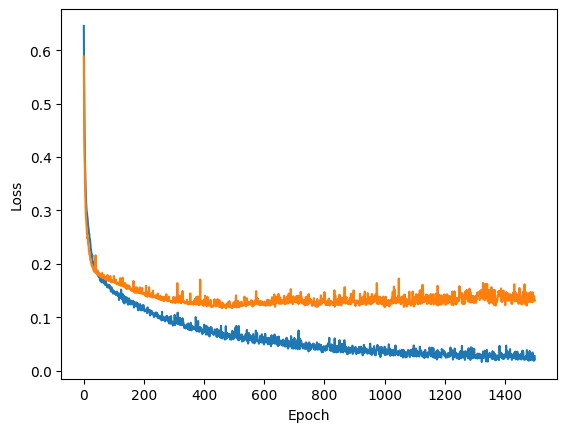

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [ ]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9738
F1_score: [0.98219573 0.9504131 ]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction we choose the class with the highest probability.

In [ ]:
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

In [ ]:
def pred_threshold(y_pred, threshold=0.5):
    y_pred_class = y_pred[:, 1] > threshold

    # confusion matrix of test dataset
    cm_true = pd.Series(np.argmax(target_df, axis=1), dtype=int)
    cm_pred = pd.Series(y_pred_class, dtype=int)
    cm = pd.crosstab(cm_true[idx_test], cm_pred[idx_test])
    if is_unique(cm_pred) == True:
        cm = cm.reindex([0,1], axis = 'columns', fill_value = 0)
    return cm

In [ ]:
def cm_eval(cm):
    # True positive rate (recall/sensitivity)
    tpr = cm.iloc[1, 1] / (cm.iloc[1, 1] + cm.iloc[1, 0])
    # True negative rate (specificity)
    tnr = cm.iloc[0, 0] / (cm.iloc[0, 0] + cm.iloc[0, 1])
    # Positive predictive value (precision)
    ppv = cm.iloc[1, 1] / (cm.iloc[1, 1] + cm.iloc[0, 1])
    # Negative predictive value
    npv = cm.iloc[0, 0] / (cm.iloc[0, 0] + cm.iloc[1, 0])
    # Accuracy
    acc = (cm.iloc[0, 0] + cm.iloc[1, 1]) / cm.sum().sum()
    # F1 score
    f1 = 2 * (ppv * tpr) / (ppv + tpr)
    # Matthews correlation coefficient
    mcc = np.sqrt((tpr * tnr * ppv * npv)) - np.sqrt((1 - tpr) * (1 - tnr) * (1 - ppv) * (1 - npv))
     
    return acc, f1, tpr, tnr, ppv, npv, mcc

In [ ]:
thresholds = np.linspace(0, 1, 5000)
threshold_scores = []

y_pred = mlp.predict(input_df, verbose=0)

for t in thresholds:
    cm = pred_threshold(y_pred, threshold=t)
    threshold_scores.append(cm_eval(cm))

acc_threshold = [x[0] for x in threshold_scores]
f1_threshold = [x[1] for x in threshold_scores]
tpr_threshold = [x[2] for x in threshold_scores]
tnr_threshold = [x[3] for x in threshold_scores]
ppv_threshold = [x[4] for x in threshold_scores]
npv_threshold = [x[5] for x in threshold_scores]
mcc_threshold = [x[6] for x in threshold_scores]

C:\Users\tomje\AppData\Local\Temp\ipykernel_26152\3555286029.py:9: RuntimeWarning: invalid value encountered in scalar divide
  npv = cm.iloc[0, 0] / (cm.iloc[0, 0] + cm.iloc[1, 0])
C:\Users\tomje\AppData\Local\Temp\ipykernel_26152\3555286029.py:7: RuntimeWarning: invalid value encountered in scalar divide
  ppv = cm.iloc[1, 1] / (cm.iloc[1, 1] + cm.iloc[0, 1])


Text(0, 0.5, 'Frequency')

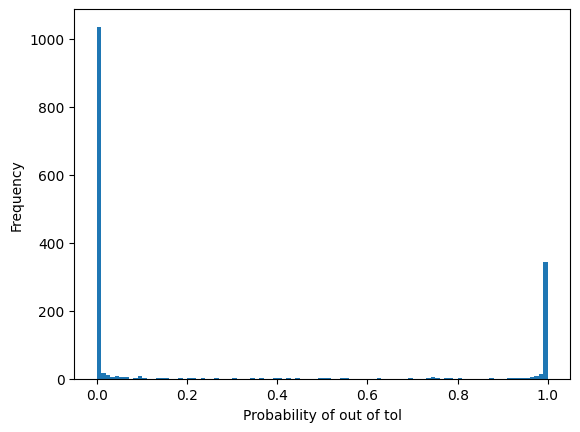

In [ ]:
fig, ax = plt.subplots()
ax.hist(y_pred[:, 1], bins=100, log=False)
ax.set_xlabel('Probability of out of tol')
ax.set_ylabel('Frequency')

Text(0.5, 1.0, 'PPV (Precision)')

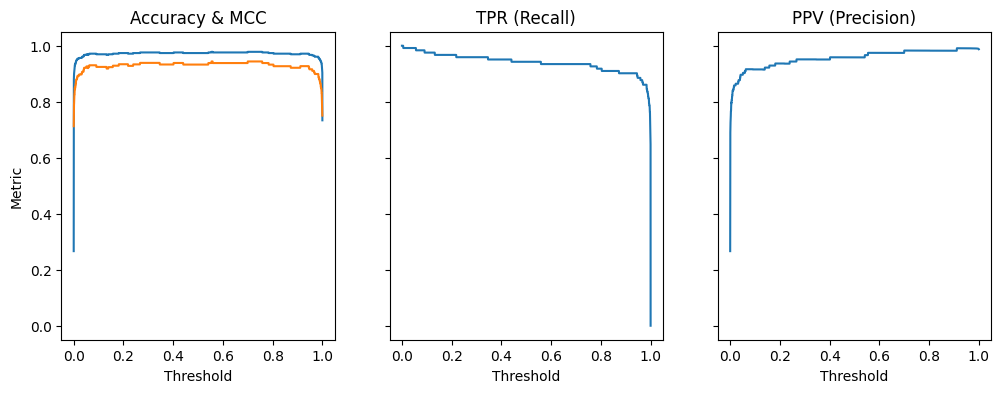

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
ax[0].plot(thresholds, acc_threshold)
ax[0].plot(thresholds, mcc_threshold)
ax[0].set_xlabel('Threshold')
ax[0].set_title('Accuracy & MCC')
ax[0].set_ylabel('Metric')

ax[1].plot(thresholds, tpr_threshold)
ax[1].set_xlabel('Threshold')
ax[1].set_title('TPR (Recall)')

ax[2].plot(thresholds, ppv_threshold)
ax[2].set_xlabel('Threshold')
ax[2].set_title('PPV (Precision)')


(0.8, 1.0)

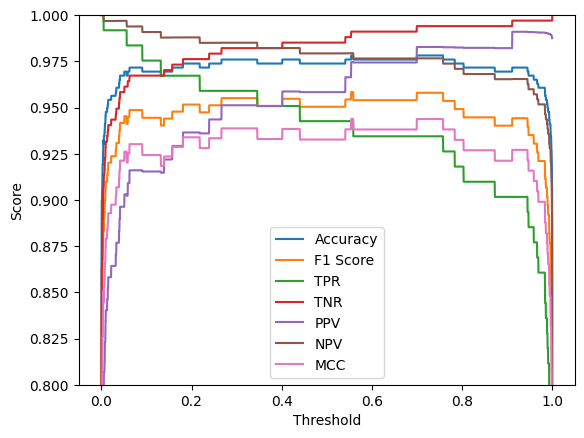

In [ ]:
fig, ax = plt.subplots()
ax.plot(thresholds, acc_threshold, label='Accuracy')
ax.plot(thresholds, f1_threshold, label='F1 Score')
ax.plot(thresholds, tpr_threshold, label='TPR')
ax.plot(thresholds, tnr_threshold, label='TNR')
ax.plot(thresholds, ppv_threshold, label='PPV')
ax.plot(thresholds, npv_threshold, label='NPV')
ax.plot(thresholds, mcc_threshold, label='MCC')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.legend()
ax.set_ylim(0.8, 1)

In [ ]:
y_pred = mlp.predict(input_df, verbose=0)

In [ ]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

In [ ]:
# Threshold based class prediction
threshold = 0.1
y_pred_class = y_pred[:, 1] > threshold

### Confusion matrix

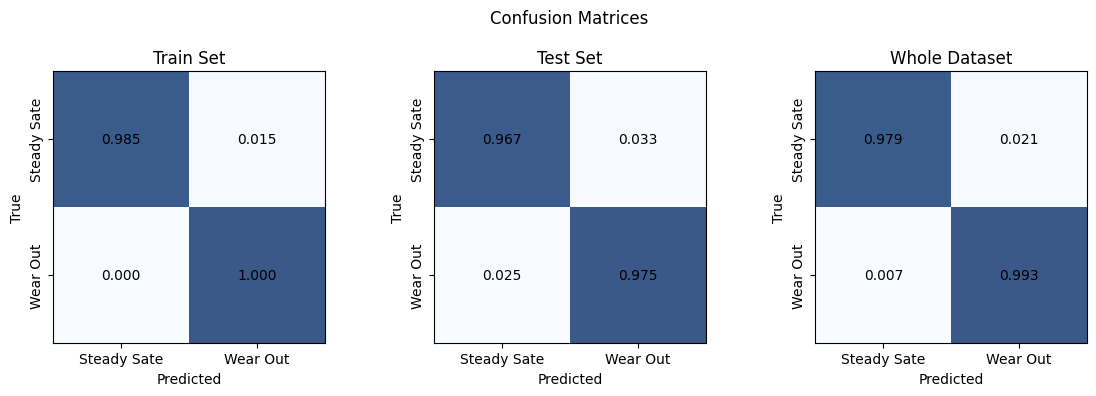

In [ ]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.3f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_xticklabels(['Steady Sate', 'Wear Out'])
    ax[i].set_yticks(np.arange(cm.shape[0]))
    ax[i].set_yticklabels(['Steady Sate', 'Wear Out'], rotation=90, va='center')
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')

    fig.tight_layout()


In [ ]:
# True positive rate (recall/sensitivity)
tpr = cm.iloc[1, 1] / (cm.iloc[1, 1] + cm.iloc[1, 0])
# True negative rate (specificity)
tnr = cm.iloc[0, 0] / (cm.iloc[0, 0] + cm.iloc[0, 1])

print(f'True Positive Rate (Out Tol): {tpr:.4f}')
print(f'True Negative Rate (In Tol): {tnr:.4f}')

True Positive Rate (Out Tol): 0.9926
True Negative Rate (In Tol): 0.9794


In [ ]:
# Positive predictive value (precision)
ppv = cm.iloc[1, 1] / (cm.iloc[1, 1] + cm.iloc[0, 1])
# Negative predictive value
npv = cm.iloc[0, 0] / (cm.iloc[0, 0] + cm.iloc[1, 0])

print(f'Positive Predictive Value (Out Tol): {ppv:.4f}')
print(f'Negative Predictive Value (In Tol): {npv:.4f}')

Positive Predictive Value (Out Tol): 0.9797
Negative Predictive Value (In Tol): 0.9925


In [ ]:
# Accuracy
acc = (cm.iloc[0, 0] + cm.iloc[1, 1]) / cm.sum().sum()
# F1 score
f1 = 2 * (cm.iloc[1, 1])/ (2 * cm.iloc[1, 1] + cm.iloc[1, 0] + cm.iloc[0, 1])

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9860
F1 Score: 0.9861


In [ ]:
# Matthews correlation coefficient
mcc = np.sqrt((tpr * tnr * ppv * npv)) - np.sqrt((1 - tpr) * (1 - tnr) * (1 - ppv) * (1 - npv))
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

Matthews Correlation Coefficient: 0.9721


### Classification Visualisation

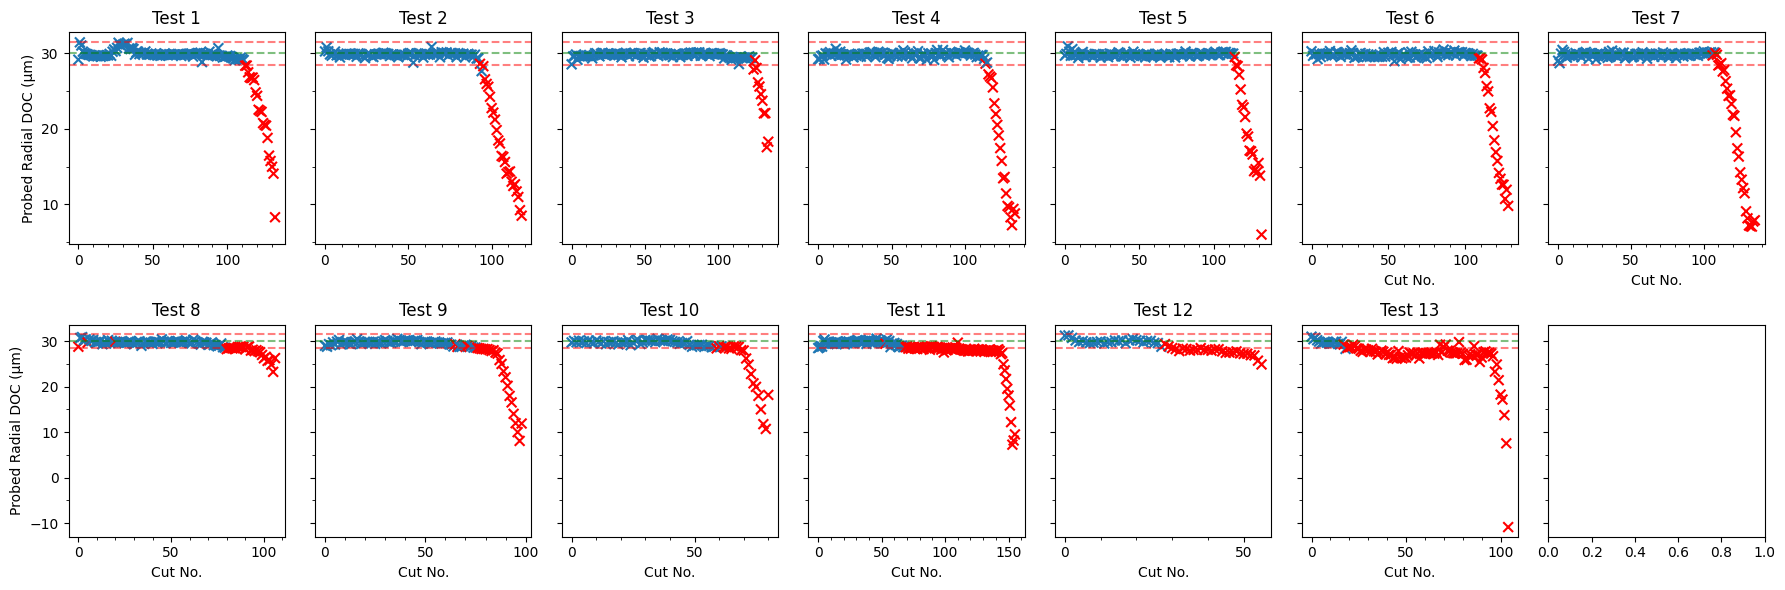

In [ ]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 1] = 'r'

fig, ax = plt.subplots(2, int(np.ceil(len(dfs)/2)), figsize=(18, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(dfs)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 7:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()

[0, 133, 252, 387, 522, 655, 784, 920, 1027, 1126, 1207, 1363, 1419, 1524]


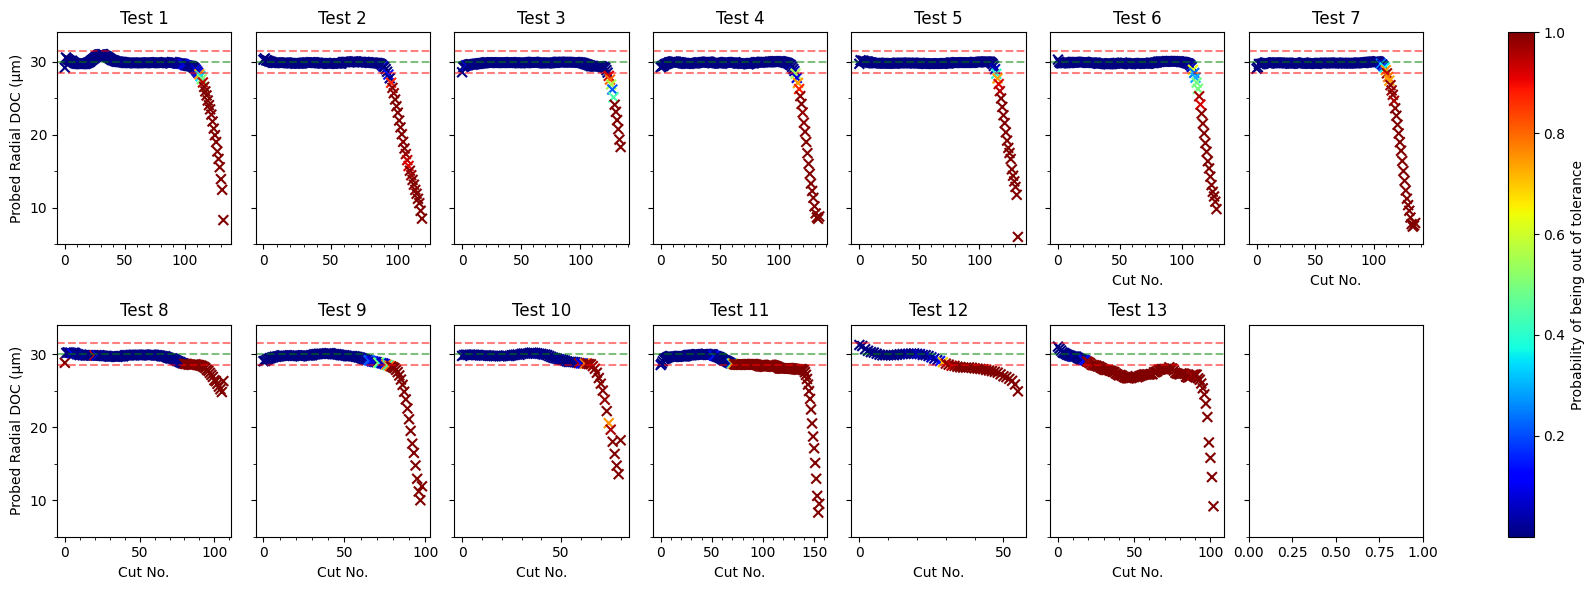

In [ ]:
# plot scatter plot with color indicating the probability of being in tolerance
prob_class1 = y_pred[:, 1]
pred_df = pd.concat(dfs.copy())
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = prob_class1

x = pred_df.index
col = prob_class1

fig, ax = plt.subplots(2, 7, figsize=(18, 6), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()
print(dfLen)

for i in range(len(dfs)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].values))
    y = dfs[i]['Probe diff'].values * 1000
    y = _smooth(y, 11)
    sc = ax[i].scatter(x=x, y=y, c=col[dfLen[i]:dfLen[i+1]], marker='x', s=50, cmap='jet')
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].set_ylim(5, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 7:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()
fig.colorbar(sc, ax=ax, label='Probability of being out of tolerance')

### Validation test data

In [ ]:
cm = pd.crosstab(cm_true[idx_val], cm_pred[idx_val])
fig, ax = plt.subplots()
ax.imshow(cm, cmap='Blues', alpha=0.8)
for ix in range(cm.shape[0]):
    for jx in range(cm.shape[1]):
        ax.text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.3f}', ha='center', va='center')
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_xticklabels(['Steady Sate', 'Wear Out'])
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_yticklabels(['Steady Sate', 'Wear Out'], rotation=90, va='center')

NameError: name 'idx_val' is not defined

# Binary classification (Drop point)

Only use two classes in or out of tolerance for probe doc.

Labelling Key:
- 0 : Pre-drop point
- 1 : Post-drop point

## Data Preprocesssing & Labelling

In [223]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_71192\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_71192\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


In [224]:
# manual drop-point selection
drop_points = [
    120,
    100,
    131,
    123,
    122,
    119,
    115,
    100,
    89,
    78,
    148,
    57,
    102,
    55,
    55,
    60,
    50,
    59,
]

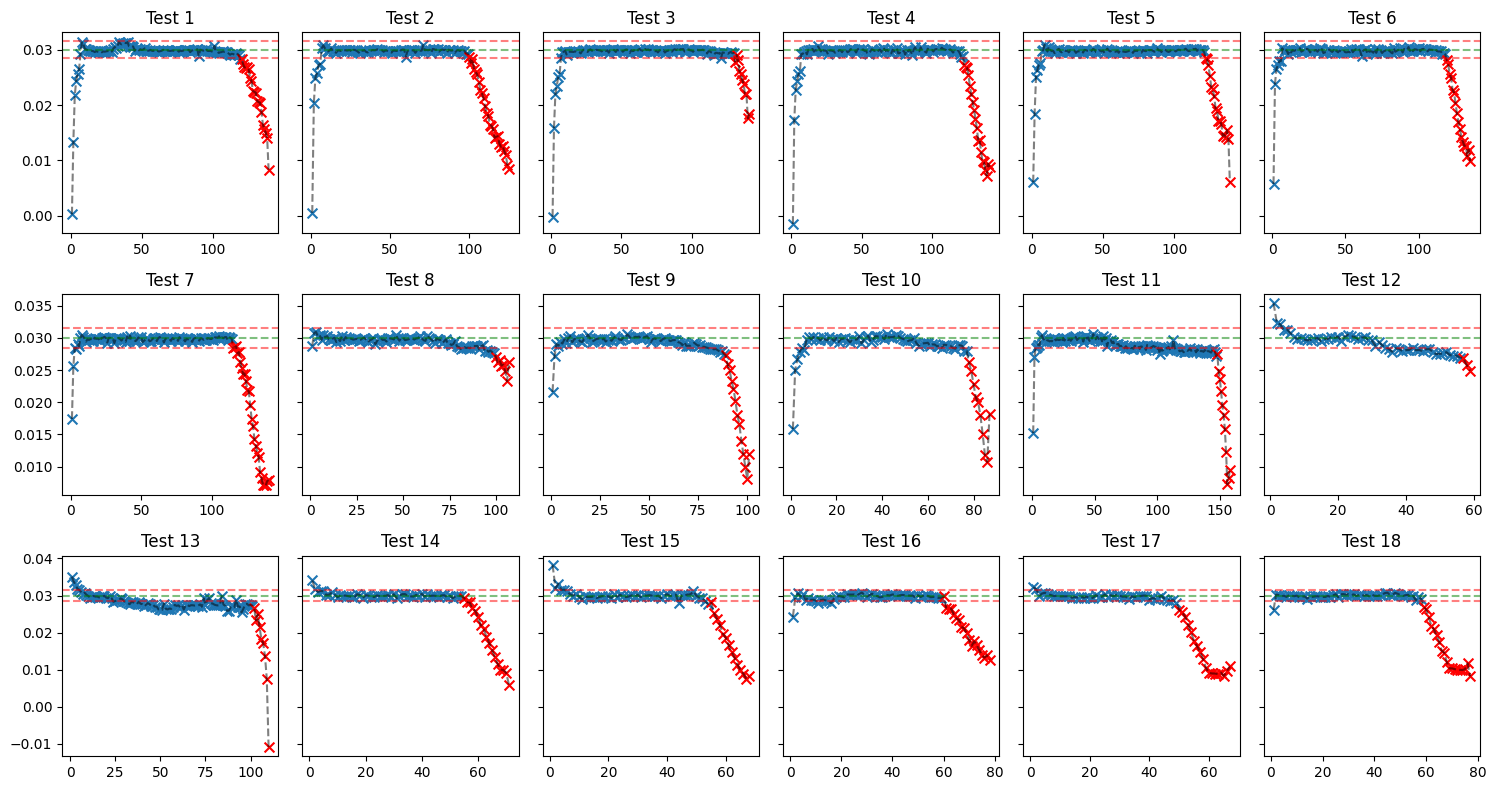

In [225]:
categories = []

fig, ax = plt.subplots(3, 6, figsize=(15, 8), sharey='row')
ax = ax.ravel()
for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    # within tolerance band
    # tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = [0 if ix < drop_points[i] else 1 for ix in x]
    tol_bool = np.array(tol_bool).astype(bool)
    categories.append(tol_bool)

    in_tol = y.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)
    ax[i].set_title(f'Test {i+1}')
fig.tight_layout()


In [226]:
# Multi-class classification
for df, cat in zip(dfs, categories):
    df['Probe class'] = cat 

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


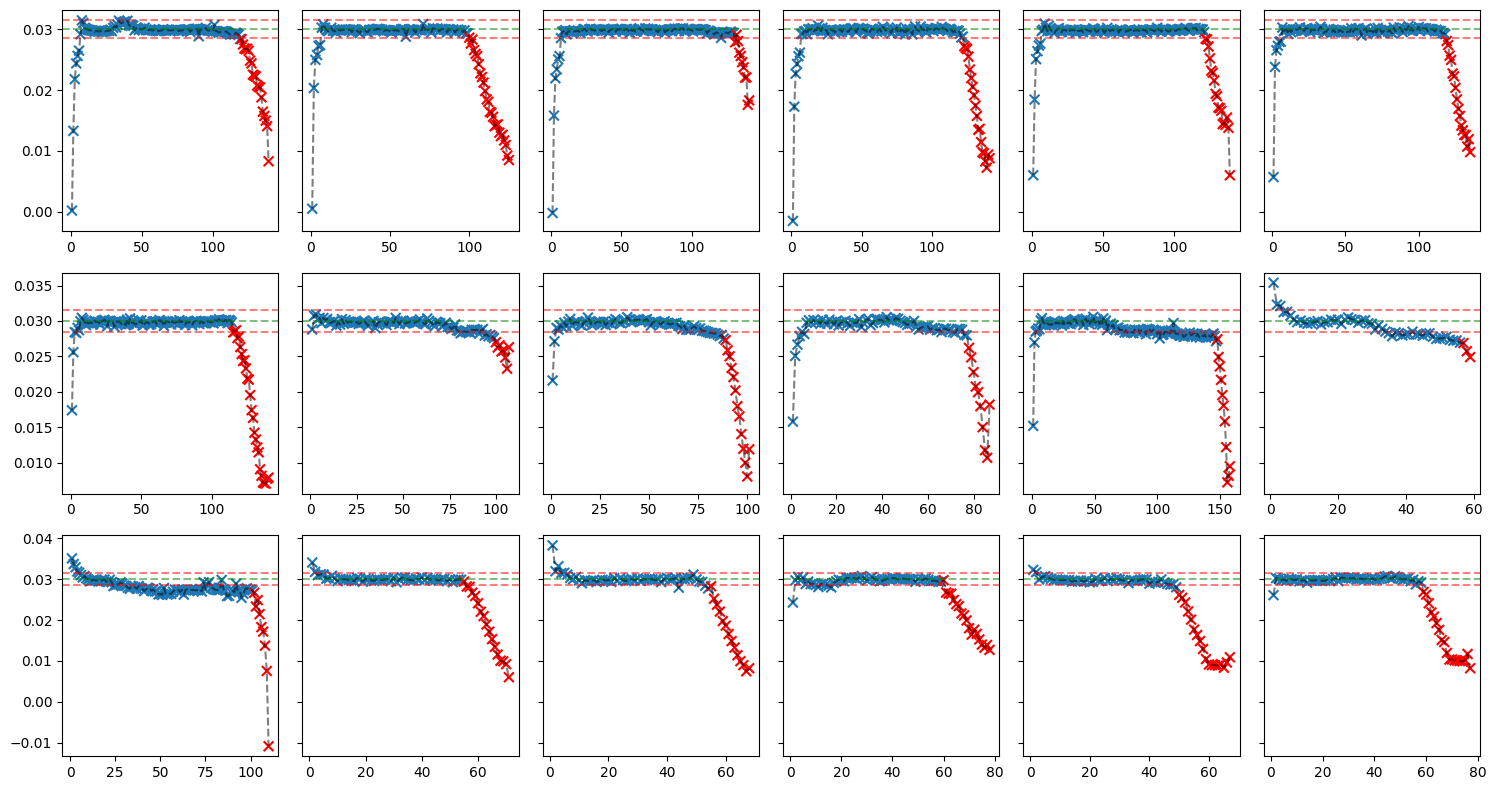

In [227]:
# scatter plot with color coding for classes

fig, ax = plt.subplots(3, 6, figsize=(15, 8), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## ML Data Setup

In [228]:
# Join all exp dataframes
main_df = pd.concat(dfs, ignore_index=True)
# Remove any rows with NaN values, mainly at the start of the experiment
main_df = main_df.dropna()
# Reset dataframe index
main_df = main_df.reset_index(drop=True)

# Remove unwanted feature columns from dataframe
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Mean radius',
                                'Radius diff',
                                'Avg probe',
                                'Probe diff',
                                # 'Freq 10 kHz',
                                # 'Probe cat',
                                ])
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 1943 rows x 10 cols


RMS   Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0  0.039208  15.358375   1.581795  0.019882    29.507773    36.712393   
1  0.289873  11.720536   8.527955  0.061386    31.941039    52.078281   
2  0.720448   6.666400   7.369736 -0.095615    36.136609    61.848164   
3  0.949587   5.552429   9.247926 -0.085875    35.081427    66.172557   
4  0.974782   5.480675   8.517215 -0.073499    34.281257    66.067365   

   Freq 134 kHz  Freq 350 kHz  Freq 900 kHz  Probe class  
0     16.873432     -2.844005    -17.895705        False  
1     39.609882     19.105036    -14.475323        False  
2     47.254065     26.394282    -10.499393        False  
3     48.616375     27.325377     -9.707462        False  
4     48.321941     26.678019    -10.607793        False

In [229]:
# Split into input and target dataframes
input_df = main_df.iloc[:, :-1].copy()
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')

target_df = main_df.iloc[:, -1].copy()
target_df = keras.utils.to_categorical(target_df)
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')

Input df : 1943 rows x 9 cols
Target df : 1943 rows x 2 cols


In [230]:
target_df

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [231]:
# Show percentage of each class within dataframe
percent = np.sum(target_df, axis=0) / np.sum(target_df) * 100
print('Dataset Class Split:')
for i, p in enumerate(percent):
    print(f'Class {i}: {p:.2f}%')

Dataset Class Split:
Class 0: 85.69%
Class 1: 14.31%


In [232]:
# Split data into training and testing sets, stratifiy keeps the class distribution the same in both sets
idx = np.arange(input_df.shape[0])
idx_train, idx_test = train_test_split(idx,
                                       test_size=0.3,
                                       random_state=16,
                                       stratify=target_df,
                                       )

print(f'Training set: {len(idx_train)} samples')
print(f'Testing set: {len(idx_test)} samples')

Training set: 1360 samples
Testing set: 583 samples


In [233]:
# Scale input data based on solely the training set
scaler = MinMaxScaler()
scaler.fit(input_df.iloc[idx_train])
input_df = scaler.transform(input_df)

## Classification Model

### Setup

In [246]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape=(input_df.shape[1],)))
mlp.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=None))
mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=None))
mlp.add(keras.layers.Dropout(0.01))
# mlp.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
# mlp.add(keras.layers.Dropout(0.01))
mlp.add(keras.layers.Dense(target_df.shape[1], activation='softmax'))

In [247]:
# Compile the model
mlp.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'f1_score'],
            )

### Training

In [248]:
history = mlp.fit(input_df[idx_train],
                  target_df[idx_train],
                  epochs=2_000,
                  batch_size=128,
                  validation_data=(input_df[idx_test], target_df[idx_test]),
                  verbose=0,
                  callbacks=[TqdmCallback(verbose=0, tqdm_class=tqdm.tqdm),],
                  )

100%|██████████| 2000/2000 [02:42<00:00, 12.28epoch/s, accuracy=0.991, f1_score=tf.Tensor([0.99485856 0.96891195], shape=(2,), dtype=float32), loss=0.0225, val_accuracy=0.976, val_f1_score=tf.Tensor([0.98602784 0.9146341 ], shape=(2,), dtype=float32), val_loss=0.087] 


Text(0, 0.5, 'Loss')

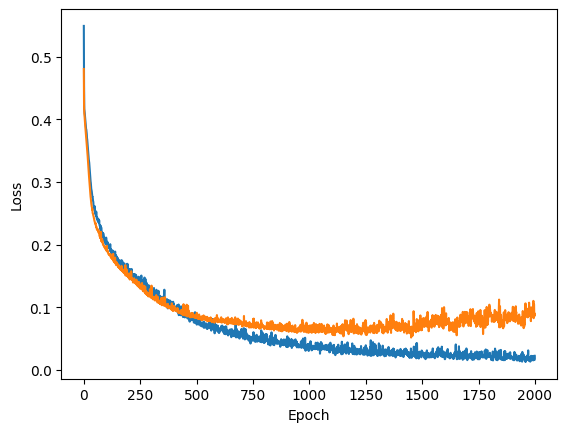

In [249]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

### Evaluation

In [250]:
sc = mlp.evaluate(input_df[idx_test], target_df[idx_test], batch_size=32, return_dict=True, verbose=0)
print('Test set evaluation:')
for key, val in sc.items():
    if key == 'loss':
        continue
    try:
        print(f'{key.capitalize()}: {val:.4f}')
    except TypeError:
        print(f'{key.capitalize()}: {val}')

Test set evaluation:
Accuracy: 0.9760
F1_score: [0.98602784 0.9146341 ]


### Thresholding

The MLP model returns the probability of that sample fitting into each class. 

Therefore to get a class prediction could choose the class with the highest probability, or set a threshold to determine the class.

In [251]:
y_pred = mlp.predict(input_df, verbose=0)

In [252]:
# Threshold based class prediction
threshold = 0.5
y_pred_class = y_pred[:, 1] > threshold

In [253]:
# Get the class with the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

### Confusion matrix

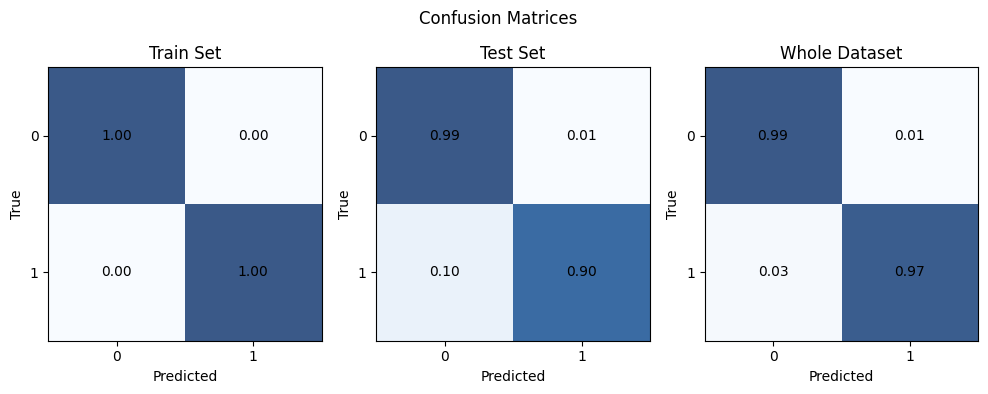

In [254]:
# confusion matrix of test train and whole dataset
cm_true = pd.Series(np.argmax(target_df, axis=1))
cm_pred = pd.Series(y_pred_class)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')

datasets = [idx_train, idx_test, np.arange(input_df.shape[0])]
for i, data in enumerate(datasets):
    cm = pd.crosstab(cm_true[data], cm_pred[data], rownames=['True'], colnames=['Predicted'])
    cm = cm.div(cm.sum(axis=1), axis='index')
    ax[i].imshow(cm, cmap='Blues', alpha=0.8)
    for ix in range(cm.shape[0]):
        for jx in range(cm.shape[1]):
            ax[i].text(x=jx, y=ix, s=f'{cm.iloc[ix, jx]:.2f}', ha='center', va='center')
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    if i == 0:
        ax[i].set_title('Train Set')
    elif i == 1:
        ax[i].set_title('Test Set')
    else:
        ax[i].set_title('Whole Dataset')

    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')


### Classification Visualisation

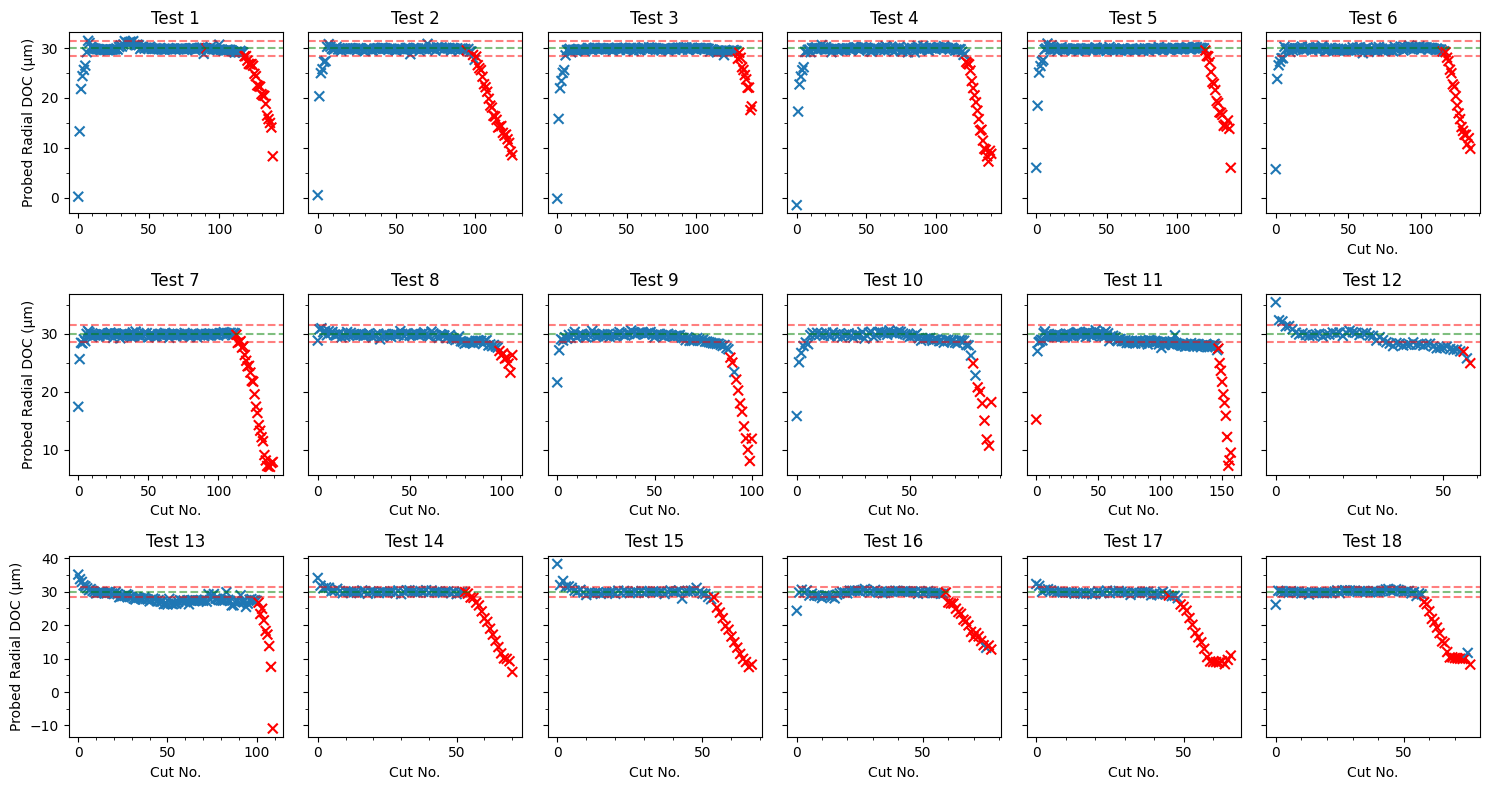

In [255]:
pred_df = pd.concat([df.copy().dropna() for df in dfs])
pred_df.reset_index(drop=True, inplace=True)
pred_df['Probe pred'] = y_pred_class

x = pred_df.index
col = np.empty_like(x, dtype=object)
col.fill('C0')
col[pred_df['Probe pred'] == 1] = 'r'

fig, ax = plt.subplots(3, 6, figsize=(15, 8), dpi=100, sharey='row')
ax = ax.ravel()

dfLen = [len(df.dropna()) for df in dfs]
dfLen = [0] + np.cumsum(dfLen).tolist()

for i in range(len(dfs)):
    # ax[i].scatter(x[dfLen[i]:dfLen[i+1]], _smooth(pred_df['Probe diff'][dfLen[i]:dfLen[i+1]] * 1000, 11), color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    x = np.arange(len(dfs[i].dropna().values))
    y = dfs[i].dropna()['Probe diff'].values * 1000
    ax[i].scatter(x=x, y=y, color=col[dfLen[i]:dfLen[i+1]], marker='x', s=50)
    ax[i].axhline(doc * 1000, color='g', ls='--', alpha=0.5)
    ax[i].axhline((doc - tol) * 1000, color='r', ls='--', alpha=0.5)
    ax[i].axhline((doc + tol) * 1000, color='r', ls='--', alpha=0.5)
    # ax[i].set_ylim(-1, 34)
    ax[i].set_title(f'Test {i+1}')
    if i > 4:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 6 or i == 12:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
fig.tight_layout()